In [221]:
#کتابخانه های لازم  را ایمپورت و دانلود میکنیم
#توضیحات مربوط به کد در قالب کامنت آورده شده است.

In [222]:
import pandas as pd
import re
import csv
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [223]:
#توضیحات دیتاست
"""دیتاست از لینک زیر قابل دانلود است:
https://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment
دیتاست شامل ده هزار توییت به همراه حس مربوط به هر توییت است.
توییت ها مربوطه به یک مناظره سیاسی میباشد.
 میخواهیم بعد از پیش پردازش با یادگیری عمیق حس توییت ها را پیش بینی کنیم. 
ابتدا از طبقه بند بیز و سپس از 
LSTM
استفاده میکنیم.
"""

'دیتاست از لینک زیر قابل دانلود است:\nhttps://www.kaggle.com/datasets/crowdflower/first-gop-debate-twitter-sentiment\nدیتاست شامل ده هزار توییت به همراه حس مربوط به هر توییت است.\nتوییت ها مربوطه به یک مناظره سیاسی میباشد.\n میخواهیم بعد از پیش پردازش با یادگیری عمیق حس توییت ها را پیش بینی کنیم. \nابتدا از طبقه بند بیز و سپس از \nLSTM\nاستفاده میکنیم.\n'

In [224]:
print("دیتاست را در یک دیتافریم میخوانیم.")

دیتاست را در یک دیتافریم میخوانیم.


In [225]:
df = pd.read_csv('Sentiment.csv')
df= df[['text','sentiment'] ]
df.head

<bound method NDFrame.head of                                                     text sentiment
0      RT @NancyLeeGrahn: How did everyone feel about...   Neutral
1      RT @ScottWalker: Didn't catch the full #GOPdeb...  Positive
2      RT @TJMShow: No mention of Tamir Rice and the ...   Neutral
3      RT @RobGeorge: That Carly Fiorina is trending ...  Positive
4      RT @DanScavino: #GOPDebate w/ @realDonaldTrump...  Positive
...                                                  ...       ...
13866  RT @cappy_yarbrough: Love to see men who will ...  Negative
13867  RT @georgehenryw: Who thought Huckabee exceede...  Positive
13868  RT @Lrihendry: #TedCruz As President, I will a...  Positive
13869  RT @JRehling: #GOPDebate Donald Trump says tha...  Negative
13870  RT @Lrihendry: #TedCruz headed into the Presid...  Positive

[13871 rows x 2 columns]>

In [226]:
#داده را قبل از پیش پردازش میبینیم.
df['text'].head

<bound method NDFrame.head of 0        RT @NancyLeeGrahn: How did everyone feel about...
1        RT @ScottWalker: Didn't catch the full #GOPdeb...
2        RT @TJMShow: No mention of Tamir Rice and the ...
3        RT @RobGeorge: That Carly Fiorina is trending ...
4        RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
                               ...                        
13866    RT @cappy_yarbrough: Love to see men who will ...
13867    RT @georgehenryw: Who thought Huckabee exceede...
13868    RT @Lrihendry: #TedCruz As President, I will a...
13869    RT @JRehling: #GOPDebate Donald Trump says tha...
13870    RT @Lrihendry: #TedCruz headed into the Presid...
Name: text, Length: 13871, dtype: object>

In [227]:
#احساسات مختلف را در دیتافریم های جداگانه میریزیم.
train_pos = df[df['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = df[df['sentiment'] == 'Negative']
train_neg = train_neg['text']
train_nut = df[df['sentiment'] == 'Neutral']
train_nut = train_nut['text']

In [228]:
#تشکیل ابر لغت میدهیم. در هر ابر از لغات کلمات بیشتر تکرار شده در آن مجموعه داده را نشان میدهیم. کلماتی که بزرگتر هستند بیشتر تکرار شده اند.
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud_draw(data, color):
    stopwords = set(STOPWORDS)
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Positive words


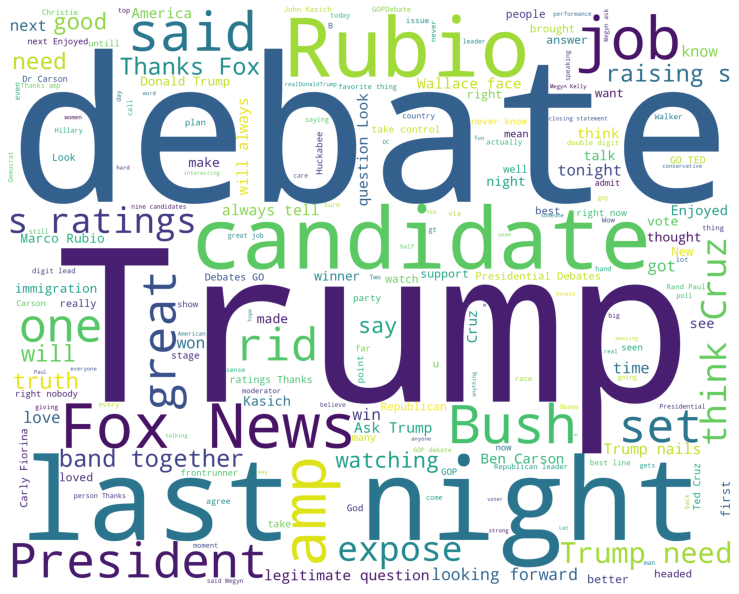

In [229]:
#ابر لغت توییت های مثبت
print("Positive words")
wordcloud_draw(train_pos,'white')

Negative words


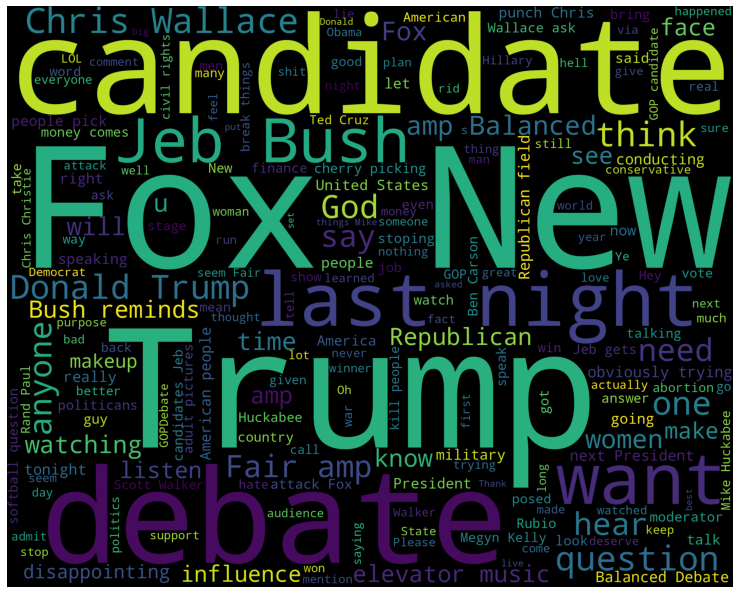

In [230]:
#ابر لغت توییت های منفی
print("Negative words")
wordcloud_draw(train_neg,'black')

Neutral words


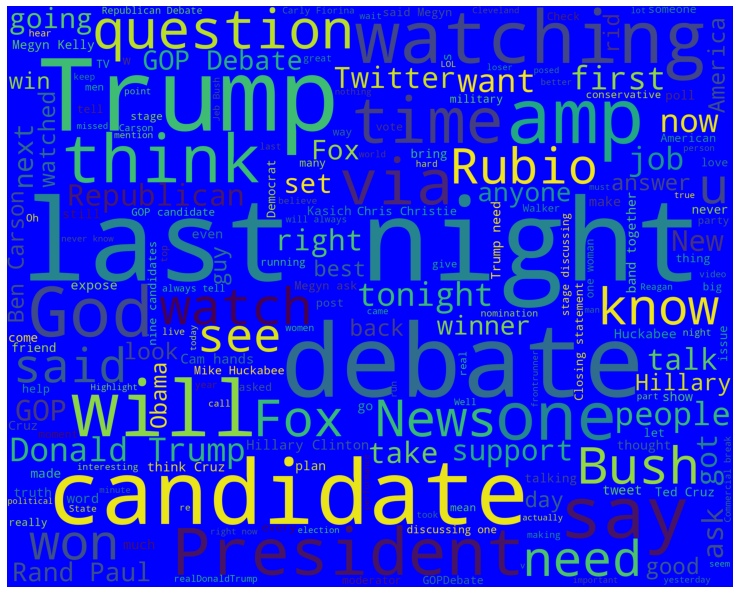

In [231]:
#ابر لغت توییت های خنثی
print("Neutral words")
wordcloud_draw(train_nut,'blue')

In [232]:
# Clean the text data
# داده ها را تمیز میکنیم.

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', str(text))

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove special characters like @
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['text'] = df['text'].apply(clean_text)

# Tokenize the text data
df['text'] = df['text'].apply(word_tokenize)

# Convert all text to lowercase
df['text'] = df['text'].apply(lambda x: [word.lower() for word in x])

# Remove stop words
# We add to words related to our task to the stopwords for english 
stop_words = set(stopwords.words('english'))
stop_words.update(['rt', 'https', 'co', 'amp'])
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

copy_df= df['text']

# Stem the remaining words
# PorterStemmer is used because of its ease of use and rapidity. 
#Frequently, the resultant stem is a shorter word with the same root meaning.
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])

#We delete the neutral tweets because it's proven to optimize our preprocessing
df = df[df.sentiment != "Neutral"]

copy2_df= df




'\n#\n'

In [233]:
import nltk
from nltk.stem import WordNetLemmatizer 

"""We either use lemmatizer or stemmizer.
Doing both stemming and lemmatization or only one will result in really SLIGHT differences.
Stemming is recommended more because lemmatization sometimes need 'pos' to perform more presicsely."""
#در اینجا لماتایز کردیم تا تفاوت عملکرد را در بیشترین کلمات تکرار شده ببینیم.


nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
copy_df = copy_df.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [234]:
#We see the dataset after preprocessing
df['text'].head
#As we can see it is different from before preprocessing

<bound method NDFrame.head of 1        [didnt, catch, full, last, night, scott, best,...
3        [carli, fiorina, trend, hour, debat, men, just...
4        [w, deliv, highest, rate, histori, presidenti,...
5        [first, day, rescind, everi, illeg, execut, ac...
6                  [like, happi, heard, go, moder, anymor]
                               ...                        
13866    [love, see, men, never, face, pregnanc, talk, ...
13867                   [thought, huckabe, exceed, expect]
13868            [presid, alway, tell, truth, said, would]
13869    [donald, trump, say, doesnt, time, polit, corr...
13870                   [head, presidenti, debat, go, ted]
Name: text, Length: 10729, dtype: object>

In [235]:
#We keep the words of the tweets in words_ne
words_ne = []
for words in df['text']:
    for word in words:
        if word not in stop_words:
            words_ne.append(word)

words_ne[:5]


['didnt', 'catch', 'full', 'last', 'night']

In [236]:
#Average size of tweet after preprocessing. It is 7 words.
tweet_num= df.shape[0]
words_num =len(words_ne)
average= words_num/tweet_num
print(average)

7.76288563705844


In [237]:
words_ne2 = []
for words in copy_df:
    for word in words:
            words_ne2.append(word)
words_ne2[:5]


['everyone', 'feel', 'climate', 'change', 'question']

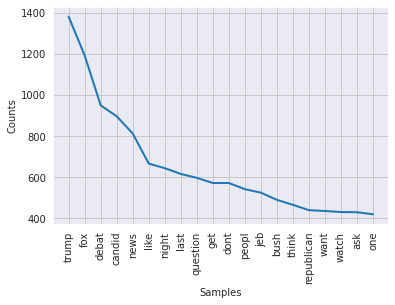

In [238]:
#We see the top most used words is the tweets.
#بعد از استم شدن.
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(words_ne)
nlp_words.plot(20);

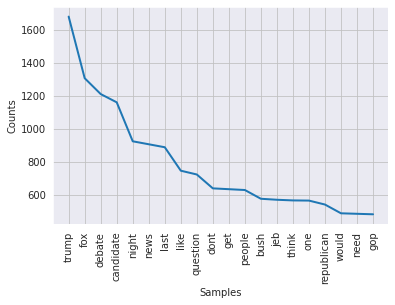

In [239]:
#بعد از لماتایز شدن.
sns.set_style('darkgrid')
nlp_words=nltk.FreqDist(words_ne2)
nlp_words.plot(20);

In [240]:

#Convert the preprocessed text data into a bag of words
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X = vectorizer.fit_transform(df['text'].apply(lambda x: ' '.join(x)))

#احساسات را به اعداد تبدیل میکنیم.
df.loc[df['sentiment'] == 'Positive','sentiment'] = 1 
df.loc[df['sentiment'] == 'Negative','sentiment'] = 0
df['sentiment']=df['sentiment'].astype('int')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.3, random_state=42)

# Train a Naive Bayes model on the training data
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict the sentiment of the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#صحت نسبتا خوبی به ما میدهد یعنی 79 درصد

Accuracy: 0.798695246971109


/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
<ipython-input-240-032c6b702df6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['sentiment'] == 'Positive','sentiment'] = 1
<ipython-input-240-032c6b702df6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['sentiment'] == 'Negative','sentiment'] = 0
<ipython-input-240-032c6b702df6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [241]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [242]:
max_fatures = 2000

#از توکنایزر استفاده میکنیم
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8583, 19) (8583, 2)
(2146, 19) (2146, 2)


In [243]:
embed_dim = 128
lstm_out = 196

#یک مدل LSTM تشکیل میدهیم.
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 19, 128)           256000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 19, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 196)               254800    
                                                                 
 dense_7 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [244]:
batch_size = 128
#مدل را ترین میکنیم
model.fit(X_train, Y_train, epochs = 15, batch_size=batch_size, verbose = 1)

Epoch 1/15
68/68 [==============================] - 23s 276ms/step - loss: 0.4852 - accuracy: 0.7933
Epoch 2/15
68/68 [==============================] - 21s 307ms/step - loss: 0.3457 - accuracy: 0.8502
Epoch 3/15
68/68 [==============================] - 12s 167ms/step - loss: 0.3013 - accuracy: 0.8699
Epoch 4/15
68/68 [==============================] - 7s 99ms/step - loss: 0.2848 - accuracy: 0.8750
Epoch 5/15
68/68 [==============================] - 7s 109ms/step - loss: 0.2618 - accuracy: 0.8845
Epoch 6/15
68/68 [==============================] - 6s 95ms/step - loss: 0.2454 - accuracy: 0.8915
Epoch 7/15
68/68 [==============================] - 7s 109ms/step - loss: 0.2289 - accuracy: 0.9011
Epoch 8/15
68/68 [==============================] - 7s 102ms/step - loss: 0.2167 - accuracy: 0.9055
Epoch 9/15
68/68 [==============================] - 7s 100ms/step - loss: 0.2021 - accuracy: 0.9147
Epoch 10/15
68/68 [==============================] - 9s 129ms/step - loss: 0.1904 - accuracy: 0.917

In [245]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
#مدل را تست میکنیم که صحت بسیار خوبی برای توییت های منفی و صحت متوسطی برای توییت های مثبت دارد
predict_x=model.predict(X_test) 
Y_pred=np.argmax(predict_x,axis=1)
df_test = pd.DataFrame({'true': Y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
print(classification_report(df_test.true, df_test.pred))

68/68 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1713
           1       0.61      0.49      0.54       433

    accuracy                           0.83      2146
   macro avg       0.74      0.71      0.72      2146
weighted avg       0.82      0.83      0.83      2146

